<strong>Problem Statement (Hypothesis):</strong><br> What’s the best allocation of assets within a portfolio? This project aims to answer that question by creating models that optimize portfolios based on annual return or risk.

Investing is an excellent way to increase capital, and it has been shown that a diversified portfolio can provide the best risk-adjusted returns. However, it isn’t always easy to determine the best mix of stocks and other assets to maximize returns and/or minimize risk in a diversified portfolio.

Having  data-driven methods for optimizing the allocation of stocks or other assets in a portfolio can be applied in  use cases, for a broad section of investors, from individuals to portfolio managers, to fund managers.

This project will use the PyPortfolioOpt library to look at diversification in stock portfolios to either maximize annual return or minimize risk based on a covariance matrix. We will look at this through three different optimizers:

Efficient Frontier
Black-Litterman
Hierarchical Risk Parity

The Efficient Frontier optimizer uses the work of Harry Markowitz and its key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation which minimizes the risk for a target return.

Black-Litterman asset allocation combines a prior estimate of returns (e.g the market-implied returns) with your own views to form a posterior estimate. This results in much better estimates of expected returns than just using the mean historical return.

Hierarchical Risk Parity uses clustering algorithms to choose uncorrelated assets. It is a portfolio diversification technique that uses machine learning (single linkage clustering) to allocate weights to asset classes based on their risk contributions. The algorithm was introduced in 2016 by Marcos López de Prado in his paper, Building Diversified Portfolios that Perform Well Out-Of-Sample.

These optimizers wa randomly generatedfstock erent theretical portfolios to determine the best allocation of capital based on the

Once we have optimized a sample portfolio of five randomly selected stocks we will then look to validate the results and determine the most effective portfolio optimization method through the use of regression models. We will model using linear regression, OLS, and Ridge on all three of the portfolio optimizations to further refine the optimizations and find the best combination of optimizer and regression model. model paramete
<br>rs.

Data sources: This project will use a csv of all S&P 500 stocks obtained from Github along with  the yfinance Python library to retrieve S&P 500 historical stock data from Yahoo Finance. Because the model will encompass the entirety of the S&P 500 it is possible (though not guaranteed) that data for all 500 stocks in the index will be used in the models. By using the same portfolios with each optimizer we will also be able to determine if one optimizer outperforms the others.

#Table of Contents

[1. Sourcing and loading](#Sourcing_and_loading)

[- Import packages](#import_packages)<br>
[- Load data](#load_data)<br>

[2. Cleaning and EDA](#clean_eda)
[- Cleaning the data](#clean_data)<br>
[- Exploring the data](#explore_data)<br>
[- Visualizing the data](#visualize_data)<br>

[3. Potfolio Optimization](#portfolio_optimization)
[- Creating the Random Portfolio](#random_portfolio)<br>
[- Efficient Frontier](#efficient_frontier)<br>
[- Black-Litterman](#black-litterman)<br>
[- Hierarchical Risk Parity](#hierarchical_risk_parity)<br>

[4. Preprocessing and Modeling](#preprocessing)

## 1. Sourcing and Loading

<a id='Sourcing_and_loading'></a>

### 1a. Import packages

<a id='import_packages'></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, discrete_allocation
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### 1b. Load data

<a id='load_data'></a>

In [2]:
# Fetch S&P 500 stock list
df_sp500 = pd.read_csv(r'C:\Users\money\Desktop\Springboard\Capstone 3\constituents.csv')
tickers = df_sp500['Symbol'].tolist()

# Download historical data for S&P 500 stocks
stock_data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2024-01-01)')


In [3]:
# Check the first few rows of the downloaded data
print(stock_data.head())

Ticker              A        AAL       AAPL       ABBV  ABNB        ABT  \
Date                                                                      
2019-01-02  63.278919  31.963160  37.845039  69.330475   NaN  63.287056   
2019-01-03  60.947739  29.581665  34.075397  67.046143   NaN  60.300270   
2019-01-04  63.057346  31.530161  35.530048  69.206169   NaN  62.021294   
2019-01-07  64.396332  32.425678  35.450974  70.216232   NaN  62.950111   
2019-01-08  65.340363  31.904110  36.126770  70.542549   NaN  62.194328   

Ticker           ACGL         ACN        ADBE        ADI  ...         WTW  \
Date                                                      ...               
2019-01-02  26.190001  130.096802  224.570007  77.771767  ...  139.077805   
2019-01-03  25.780001  125.655045  215.699997  73.073975  ...  136.160187   
2019-01-04  26.389999  130.541000  226.190002  74.848099  ...  139.839752   
2019-01-07  26.330000  130.994415  229.259995  75.318794  ...  140.871094   
2019-01-08  

## 2. Cleaning and EDA

<a id='clean_eda'></a>

### 2a. Cleaning the data

<a id='clean_data'></a>

In [4]:
#Cleaning up the download list to remove tickers that have been delisted or may be missing price data
# Function to check if data can be downloaded for a ticker
def check_ticker(ticker):
    try:
        data = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)
        if data.empty:
            raise ValueError("No data returned")
        return True
    except Exception as e:
        print(f"Failed to download {ticker}: {str(e)}")
        return False

# Filter the list by checking each ticker
clean_tickers = [ticker for ticker in tickers if check_ticker(ticker)]

# Download historical data for the clean list of S&P 500 stocks
clean_stock_data = yf.download(clean_tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

# Check the first few rows of the downloaded data
print(clean_stock_data.head())


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


Failed to download BRK.B: No data returned



1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2024-01-01)')


Failed to download BF.B: No data returned



1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")


Failed to download GEV: No data returned



1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")


Failed to download SOLV: No data returned


[*********************100%%**********************]  499 of 499 completed


Ticker              A        AAL       AAPL       ABBV  ABNB        ABT  \
Date                                                                      
2019-01-02  63.278915  31.963158  37.845039  69.330482   NaN  63.287067   
2019-01-03  60.947727  29.581665  34.075382  67.046127   NaN  60.300274   
2019-01-04  63.057350  31.530159  35.530048  69.206146   NaN  62.021309   
2019-01-07  64.396324  32.425678  35.450966  70.216225   NaN  62.950134   
2019-01-08  65.340378  31.904110  36.126770  70.542564   NaN  62.194321   

Ticker           ACGL         ACN        ADBE        ADI  ...         WTW  \
Date                                                      ...               
2019-01-02  26.190001  130.096848  224.570007  77.771774  ...  139.077805   
2019-01-03  25.780001  125.655052  215.699997  73.073975  ...  136.160217   
2019-01-04  26.389999  130.540970  226.190002  74.848091  ...  139.839722   
2019-01-07  26.330000  130.994431  229.259995  75.318779  ...  140.871094   
2019-01-08  

In [5]:
#Removing the four tickers(Symbol) that are not able to be downloaded from yfinance.

# Symbols to be removed
symbols_to_remove = ['BRK.B', 'BF.B', 'GEV', 'SOLV']

# Filter out the rows where the 'Symbol' column is in the list of symbols to remove
df_sp500 = df_sp500[~df_sp500['Symbol'].isin(symbols_to_remove)]

# Now df_sp500 should have the rows with the specified symbols removed

In [6]:
# Symbols that should have been removed
symbols_to_remove = ['BRK.B', 'BF.B', 'GEV', 'SOLV']

# Check for Existence
for symbol in symbols_to_remove:
    if symbol in df_sp500['Symbol'].values:
        print(f"{symbol} is still in the DataFrame.")
    else:
        print(f"{symbol} has been successfully removed.")

# Count Occurrences
for symbol in symbols_to_remove:
    count = df_sp500[df_sp500['Symbol'] == symbol].shape[0]
    print(f"Occurrences of {symbol}: {count}")

BRK.B has been successfully removed.
BF.B has been successfully removed.
GEV has been successfully removed.
SOLV has been successfully removed.
Occurrences of BRK.B: 0
Occurrences of BF.B: 0
Occurrences of GEV: 0
Occurrences of SOLV: 0


### 2b. Explore the data

<a id='explore_data'></a>

In [7]:
clean_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Columns: 499 entries, A to ZTS
dtypes: float64(499)
memory usage: 4.8 MB


In [8]:
clean_stock_data.describe()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
count,1258.000000,1258.000000,1258.000000,1258.000000,768.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,112.619419,19.214294,121.413824,104.188438,139.322220,97.875701,46.247520,251.006093,423.474094,139.510942,...,204.567298,27.807288,97.039052,59.830164,67.726845,91.171243,107.951597,126.024167,321.095039,154.815797
std,29.361185,6.886768,46.758670,32.850876,28.904823,16.350800,15.884784,61.771669,115.398594,31.868775,...,25.266112,5.553772,22.103893,6.131166,25.815748,18.096321,16.770987,16.026995,120.674836,33.116698
min,60.947727,9.040000,34.075382,50.956898,82.489998,58.399960,22.240000,125.655052,215.699997,73.073975,...,136.160217,11.533242,42.583981,41.241585,25.646788,53.968819,52.494675,75.791985,146.880005,78.659050
25%,82.176216,13.835000,75.294868,73.084234,116.497499,82.872709,34.902501,191.444221,326.987495,107.020264,...,186.656525,23.670054,81.124376,56.130879,50.157196,75.776711,93.651611,114.211628,234.247505,129.908558
50%,118.633560,16.835000,132.488838,99.651077,137.704994,101.447189,41.705000,264.063110,419.380005,146.701721,...,202.788155,29.106069,97.909634,60.598328,58.274460,90.419487,109.769775,124.762581,277.934998,158.510201
75%,134.066044,23.437500,158.011345,137.917816,162.277496,109.879164,48.155001,302.680809,504.722496,164.731892,...,225.149986,31.981935,112.609692,64.083830,93.878708,104.944361,122.358128,138.491051,394.099991,176.137333
max,176.085098,36.441425,197.857529,160.493271,216.839996,135.071182,90.000000,400.401398,688.369995,199.937866,...,258.842712,39.106033,149.413559,73.069794,118.014030,133.825974,140.204865,169.488922,614.549988,242.464096


In [9]:
# Check for missing values in the DataFrame

# Find rows with at least one missing value
rows_with_missing_data = clean_stock_data[clean_stock_data.isnull().any(axis=1)]

# Display the rows with missing data
print("Rows with missing data:")
print(rows_with_missing_data)

Rows with missing data:
Ticker               A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2019-01-02   63.278915  31.963158   37.845039   69.330482         NaN   
2019-01-03   60.947727  29.581665   34.075382   67.046127         NaN   
2019-01-04   63.057350  31.530159   35.530048   69.206146         NaN   
2019-01-07   64.396324  32.425678   35.450966   70.216225         NaN   
2019-01-08   65.340378  31.904110   36.126770   70.542564         NaN   
...                ...        ...         ...         ...         ...   
2023-09-27  109.912903  12.610000  169.988831  148.788055  134.029999   
2023-09-28  111.404930  12.920000  170.248184  147.933014  136.470001   
2023-09-29  111.225883  12.810000  170.766830  144.833450  137.210007   
2023-10-02  110.533180  12.750000  173.300262  144.046432  136.559998   
2023-10-03  109.895302  12.290000  171.953751  143.249680  127.730003   

Ticker            ABT     

In [10]:
# Calculate the percentage of missing data for each column
missing_percentage = clean_stock_data.isnull().mean() * 100

# Filter to show only columns with missing data
missing_percentage = missing_percentage[missing_percentage > 0]

# Display the percentage of missing data for columns that have it
print("Percentage of missing data in columns with missing data:")
print(missing_percentage)

Percentage of missing data in columns with missing data:
Ticker
ABNB    38.950715
CARR    24.244833
CEG     61.049285
CTVA     7.869634
DOW      4.213037
FOX      3.815580
FOXA     3.736089
GEHC    79.252782
KVUE    86.804452
OTIS    24.244833
UBER     7.074722
VLTO    95.151033
dtype: float64


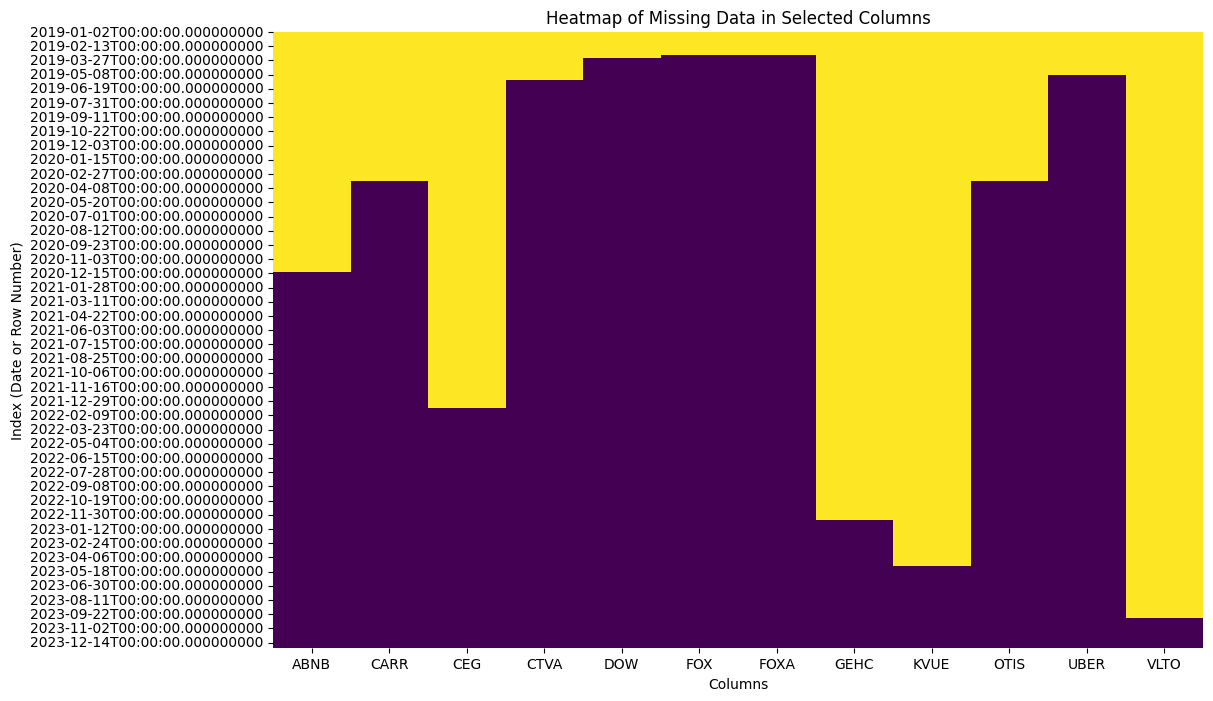

In [11]:
import seaborn as sns

# List of columns with missing data
columns_with_missing_data = ['ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO']

# Filter the DataFrame to include only these columns
filtered_data = stock_data[columns_with_missing_data]

# Generate a heatmap to visualize where the missing data is
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data in Selected Columns')
plt.xlabel('Columns')
plt.ylabel('Index (Date or Row Number)')
plt.show()

In [12]:
#Examining the list of S&P 500 tickers to see what features we have
df_sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [13]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 499 non-null    object
 1   Security               499 non-null    object
 2   GICS Sector            499 non-null    object
 3   GICS Sub-Industry      499 non-null    object
 4   Headquarters Location  499 non-null    object
 5   Date added             499 non-null    object
 6   CIK                    499 non-null    int64 
 7   Founded                499 non-null    object
dtypes: int64(1), object(7)
memory usage: 35.1+ KB


### 2c. Visualize the data

<a id='visualize_data'></a>

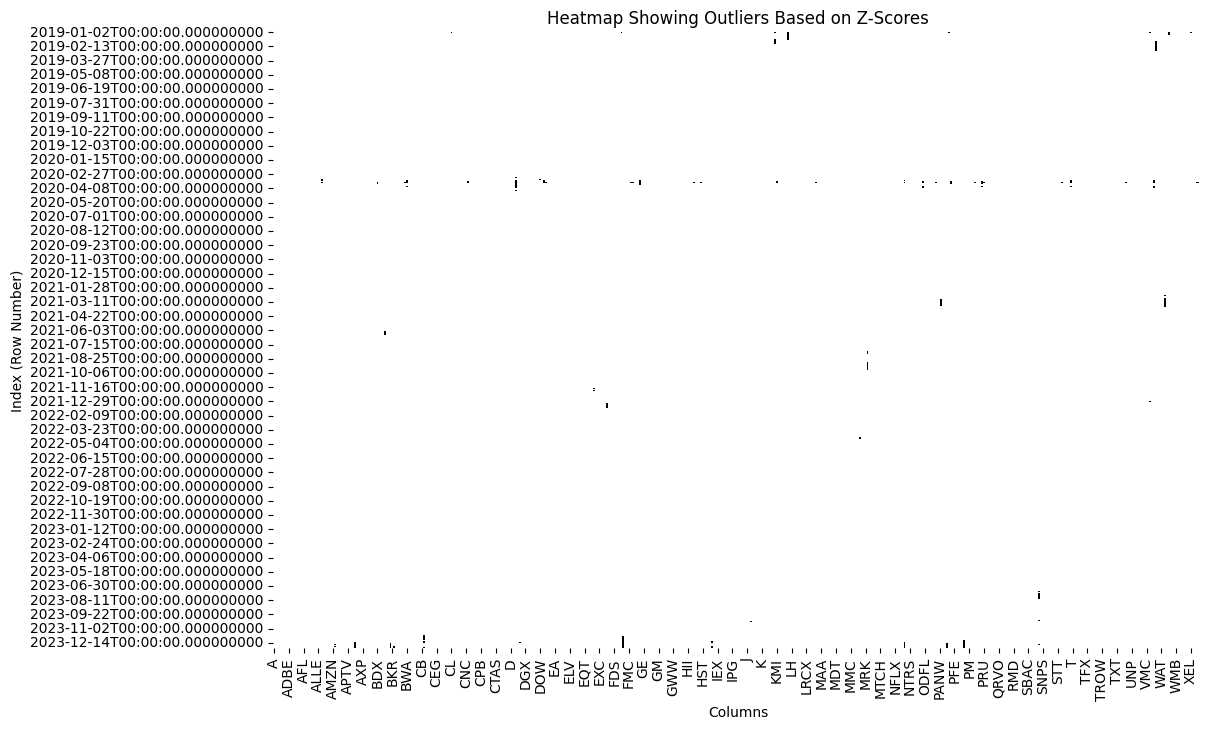

In [14]:
# Calculation of Z-scores to identify potential outliers

import seaborn as sns

# Calculate Z-scores for the entire DataFrame
z_scores = (stock_data - stock_data.mean()) / stock_data.std()

# Define a threshold for identifying outliers
threshold = 3

# Create a boolean mask where True indicates an outlier
outlier_mask = (z_scores.abs() > threshold)

# Plotting the heatmap of the outlier mask
plt.figure(figsize=(12, 8))
sns.heatmap(outlier_mask, cmap='binary', cbar=False)
plt.title('Heatmap Showing Outliers Based on Z-Scores')
plt.xlabel('Columns')
plt.ylabel('Index (Row Number)')
plt.show()

In [15]:
# Looking at the GICS sector and sub-industry features for possible segmentation later

# Count the occurrences of each 'GICS Sector'
sector_counts = df_sp500['GICS Sector'].value_counts()

# Count the occurrences of each 'GICS Sub-industry'
sub_industry_counts = df_sp500['GICS Sub-Industry'].value_counts()

# Display the results
print("GICS Sector Counts:")
print(sector_counts)
print("\nGICS Sub-Industry Counts:")
print(sub_industry_counts)

GICS Sector Counts:
Industrials               78
Financials                70
Information Technology    65
Health Care               63
Consumer Discretionary    52
Consumer Staples          37
Real Estate               31
Utilities                 30
Materials                 28
Energy                    23
Communication Services    22
Name: GICS Sector, dtype: int64

GICS Sub-Industry Counts:
Health Care Equipment                           18
Semiconductors                                  15
Industrial Machinery & Supplies & Components    14
Electric Utilities                              14
Aerospace & Defense                             12
                                                ..
Agricultural & Farm Machinery                    1
Consumer Electronics                             1
Copper                                           1
Commodity Chemicals                              1
Timber REITs                                     1
Name: GICS Sub-Industry, Length: 124, dty

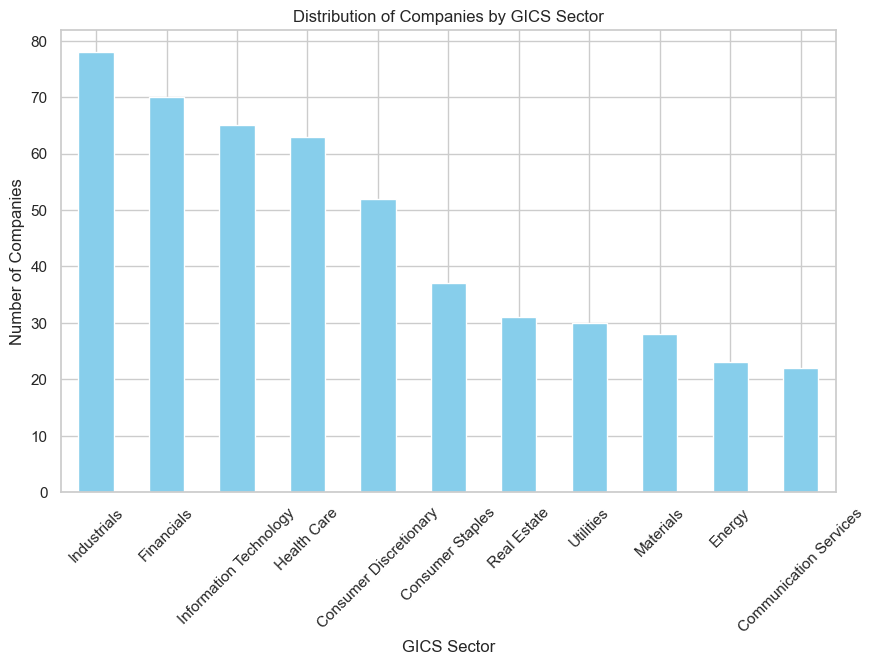

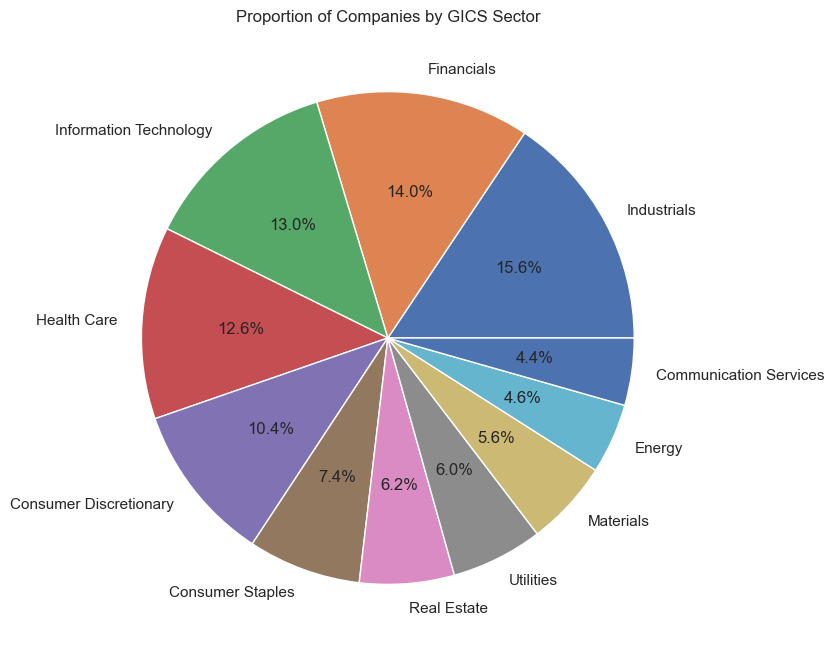

In [16]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart for GICS Sector
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Companies by GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

# Create a pie chart for GICS Sector
plt.figure(figsize=(8, 8))
sector_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Companies by GICS Sector')
plt.ylabel('')  # Hide the y-label
plt.show()

C:\Users\money\AppData\Local\Temp\ipykernel_33008\3797876563.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x700 with 0 Axes>

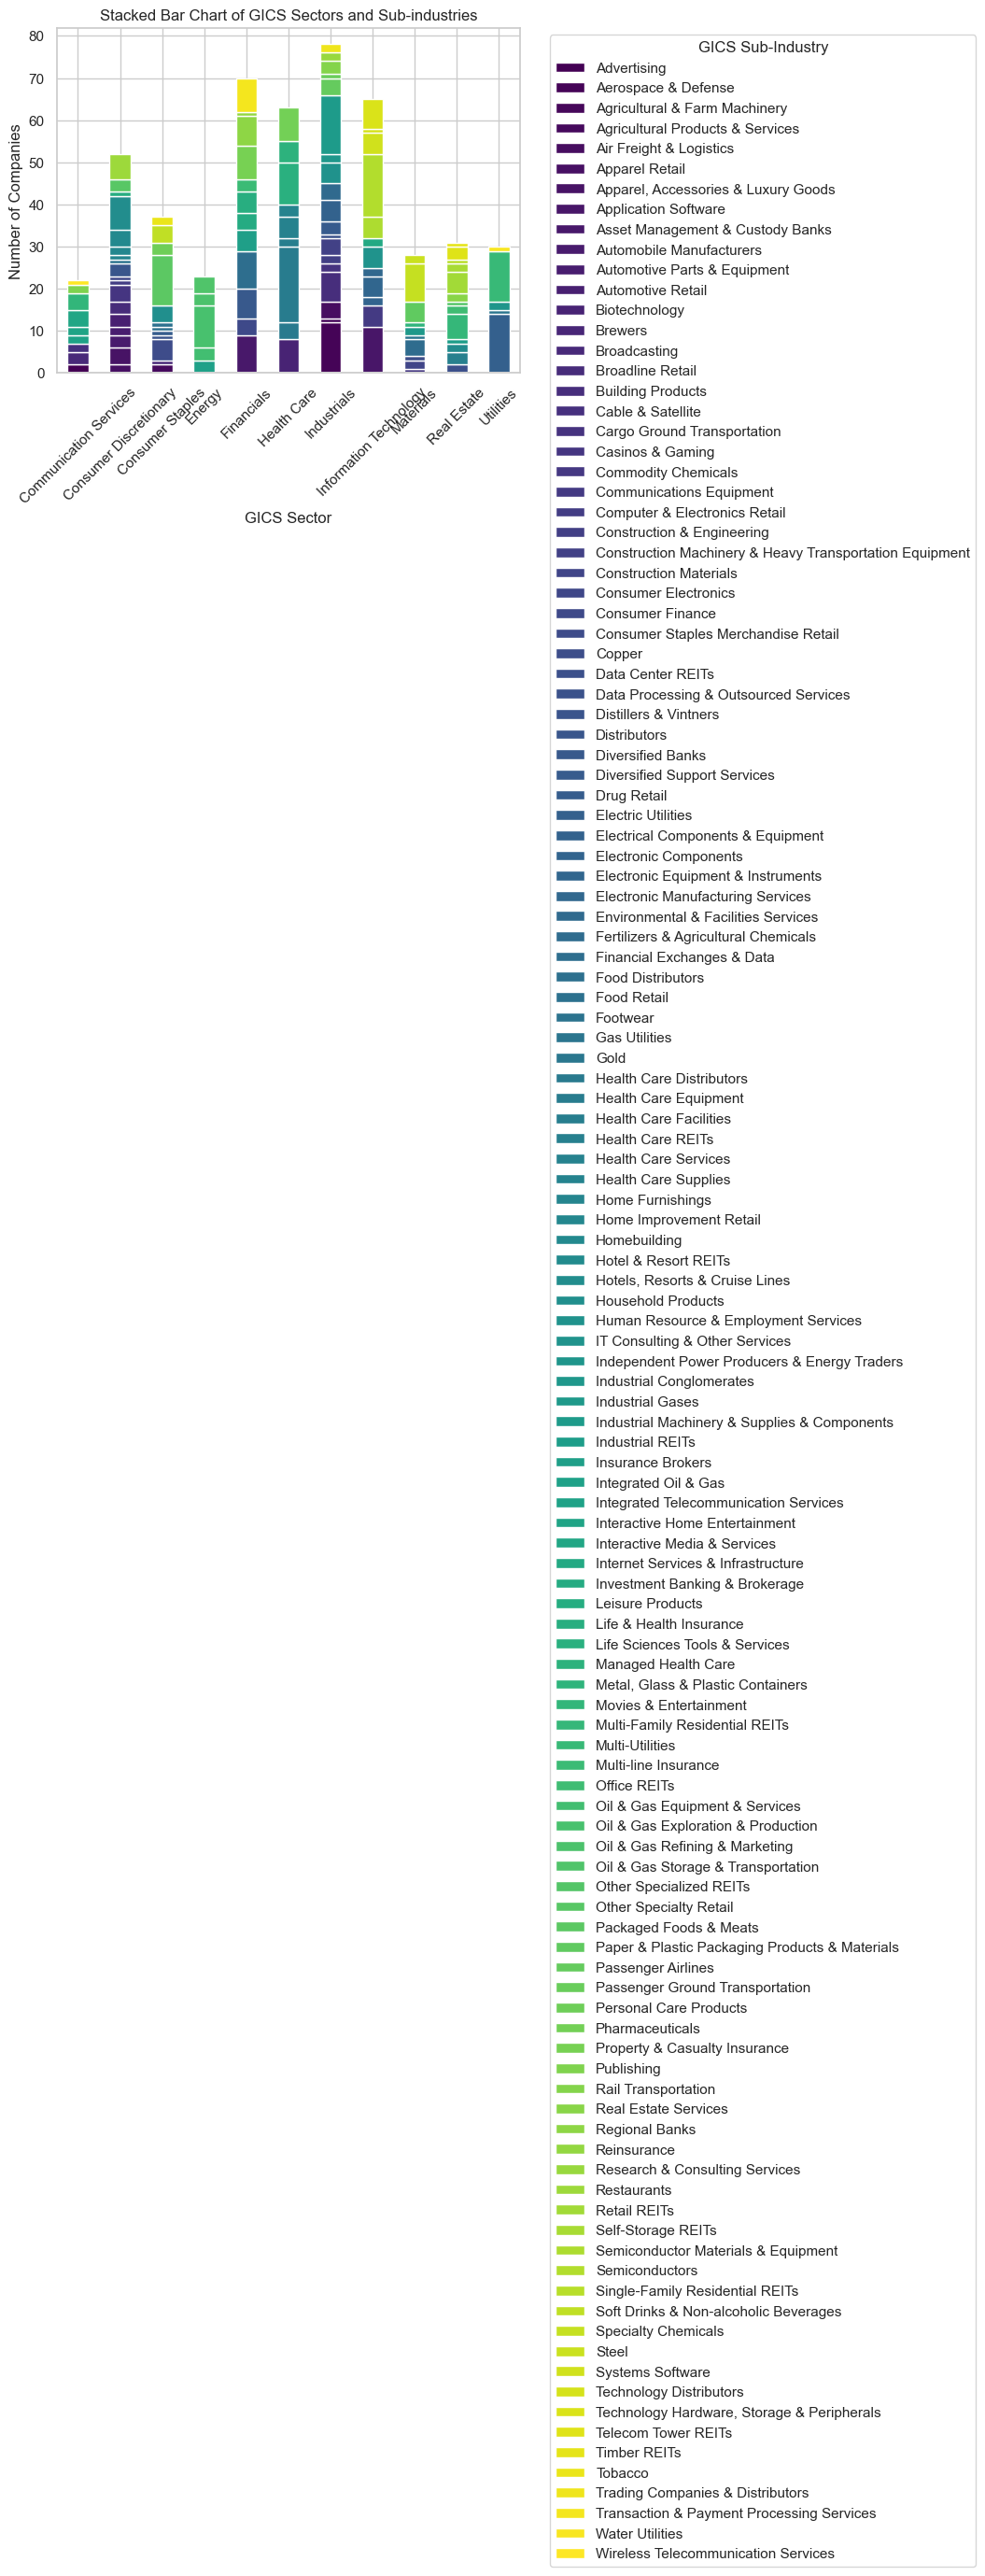

In [17]:
#Visualizing the industry data

# Prepare data for stacked bar chart
pivot_df = df_sp500.groupby(['GICS Sector', 'GICS Sub-Industry']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of GICS Sectors and Sub-industries')
plt.xlabel('GICS Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.legend(title='GICS Sub-Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

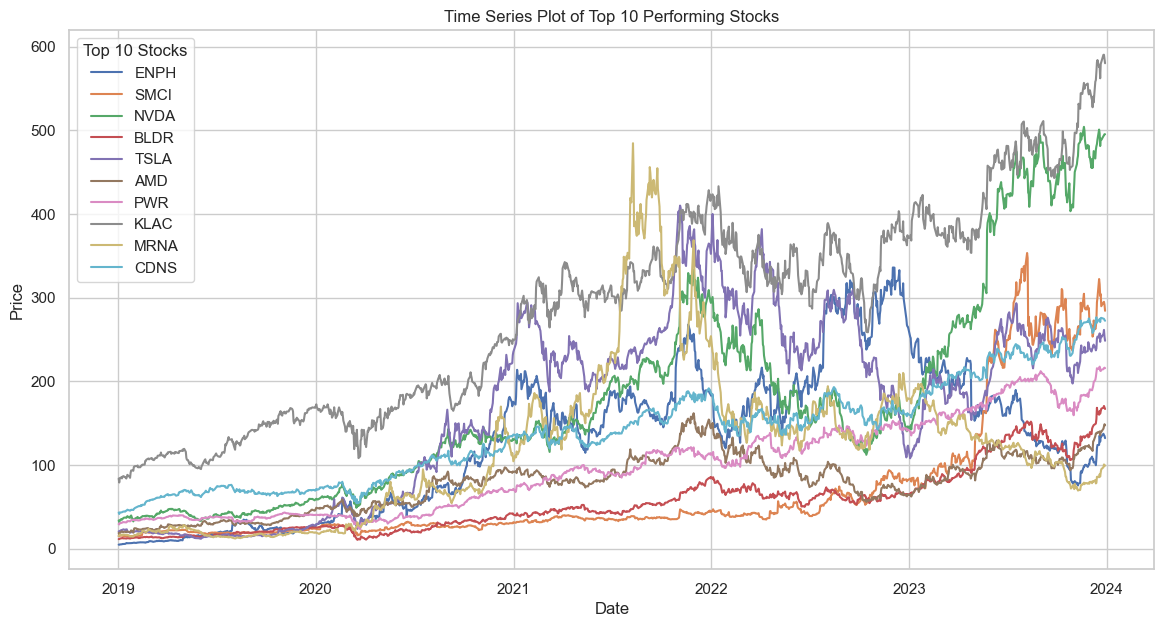

In [18]:
# Plot returns for top 10 best performing stocks

# Calculate daily returns
daily_returns = clean_stock_data.pct_change()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Find the final cumulative return for each stock to determine the top 10
final_returns = cumulative_returns.iloc[-1].sort_values(ascending=False)

# Get the names of the top 10 performing stocks
top_10_stocks = final_returns.head(10).index

# Plot the stock data for the top 10 stocks
plt.figure(figsize=(14, 7))
for column in top_10_stocks:
    plt.plot(clean_stock_data.index, clean_stock_data[column], label=column)

plt.title('Time Series Plot of Top 10 Performing Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Top 10 Stocks')
plt.show()

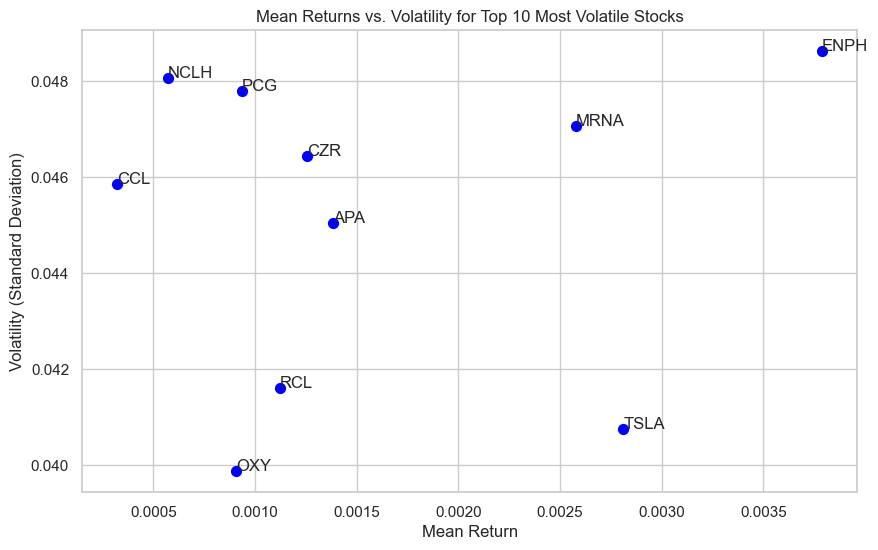

In [19]:
# Top ten most volatile stocks

# Calculate daily returns
daily_returns = clean_stock_data.pct_change()

# Calculate mean and standard deviation (volatility) of daily returns for each stock
means = daily_returns.mean()
volatilities = daily_returns.std()

# Combine the means and volatilities into a DataFrame
volatility_data = pd.DataFrame({
    'Mean Return': means,
    'Volatility': volatilities
})

# Sort the stocks by volatility (standard deviation)
top_10_volatile_stocks = volatility_data.sort_values(by='Volatility', ascending=False).head(10)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_10_volatile_stocks['Mean Return'], top_10_volatile_stocks['Volatility'], color='blue', s=50)
plt.title('Mean Returns vs. Volatility for Top 10 Most Volatile Stocks')
plt.xlabel('Mean Return')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True)

# Annotate stock names on the plot
for i in top_10_volatile_stocks.index:
    plt.annotate(i, (top_10_volatile_stocks.loc[i, 'Mean Return'], top_10_volatile_stocks.loc[i, 'Volatility']))

plt.show()

## 3. Portfolio Optimization

<a id='portfolio_optimization'></a>

Below we explore the three different portfolio optimization methods - Efficient Frontier, Black-Litterman, and Hierarchical Risk Parity - on a random portfolio of 5 stocks from the df_sp500 dataset. We ensure diversity by limiting the selection to include no more than two stocks from any specific GICS Sector.

### 3a. Creating a random portfolio

<a id='random_portfolio'></a>

In [58]:
# Ensure the GICS Sector column exists and is correct
if 'GICS Sector' not in df_sp500.columns:
    raise ValueError("GICS Sector column is missing or mislabeled")

# Create an empty list to hold selected stocks
portfolio = []

# Group stocks by GICS Sector
grouped = df_sp500.groupby('GICS Sector')

# Randomly select up to 2 stocks from each sector
for name, group in grouped:
    selected_stocks = group.sample(n=min(2, len(group)), random_state=np.random.RandomState())
    portfolio.append(selected_stocks)

# Concatenate all selected stocks into a single DataFrame
df_portfolio = pd.concat(portfolio).sample(n=5, random_state=np.random.RandomState())  # Ensure the portfolio has exactly 5 stocks

# Print the selected portfolio
print("Selected Portfolio:")
print(df_portfolio[['Symbol', 'GICS Sector']])
df_portfolio.to_csv('df_portfolio.csv')

Selected Portfolio:
    Symbol       GICS Sector
98     CNP         Utilities
10     APD         Materials
28     AIG        Financials
76      BR       Industrials
125    STZ  Consumer Staples


### 3b. Efficient Frontier

<a id='efficient_frontier'></a>

Now we optimize asset allocation of the randomly generated portfolio using the Efficient Frontier model. We do this using the PyPortfolioOpt library,  a tool designed specifically for portfolio optimization in Python. This process involves calculating expected returns, the covariance matrix for the portfolio, and then using these to determine the weights that either maximize the Sharpe ratio or minimize volatility.

In [48]:
# Filter the clean_stock_data to include only the stocks present in df_portfolio
selected_stocks = df_portfolio['Symbol'].unique()  # Extract unique stock symbols
filtered_data = clean_stock_data[selected_stocks]

# Calculate expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(filtered_data)
S = risk_models.sample_cov(filtered_data)

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:", cleaned_weights)

# Display expected performance of the portfolio
ef.portfolio_performance(verbose=True)

# Calculate and display the percentage performance of each stock
# Loop through each stock in the portfolio to print its expected return
for ticker in df_portfolio['Symbol'].unique():  # or selected_stocks if defined elsewhere
    expected_return = mu[ticker]
    print(f"Expected annual return for {ticker}: {expected_return:.2%}")

Optimized Portfolio Weights: OrderedDict([('MDLZ', 0.3224), ('LULU', 0.37248), ('CDW', 0.30513), ('NEM', 0.0), ('COP', 0.0)])
Expected annual return: 24.8%
Annual volatility: 25.7%
Sharpe Ratio: 0.89
Expected annual return for MDLZ: 15.24%
Expected annual return for LULU: 32.98%
Expected annual return for CDW: 24.98%
Expected annual return for NEM: 7.41%
Expected annual return for COP: 17.04%


#### Visualizing the Efficient Frontier

Expected annual return: 24.8%
Annual volatility: 25.7%
Sharpe Ratio: 0.89


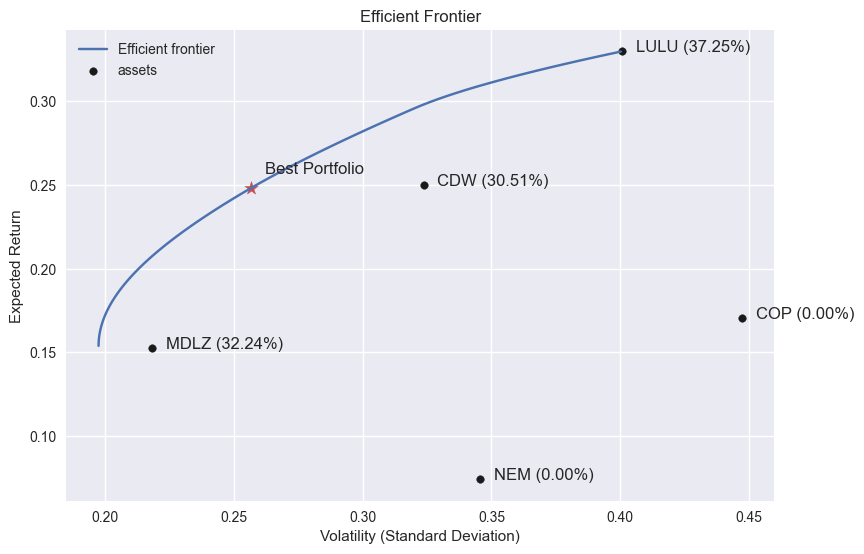

In [30]:
from pypfopt import plotting

# Create a new Efficient Frontier object for plotting
plotting_ef = EfficientFrontier(mu, S)

# Plot the Efficient Frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(plotting_ef, ax=ax, show_assets=True)

# Overlay asset tickers as labels with weights
for txt in selected_stocks:
    if txt in cleaned_weights:
        ax.annotate(f"{txt} ({cleaned_weights[txt]:.2%})", (S.loc[txt, txt]**0.5, mu[txt]), 
                    xytext=(10,0), textcoords='offset points')

# Find the optimal portfolio for marking
ef_opt = EfficientFrontier(mu, S)
sharpe_pwt = ef_opt.max_sharpe()
sharpe_perf = ef_opt.portfolio_performance(verbose=True)
ax.scatter(sharpe_perf[1], sharpe_perf[0], marker="*", s=100, c='r', label='Best Portfolio')

# Annotate the 'Best Portfolio' point
ax.annotate('Best Portfolio', (sharpe_perf[1], sharpe_perf[0]), xytext=(10,10), textcoords='offset points')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.show()

### 3c. Black-Litterman

Now we want to look at potentially improving the performance of our optimization. We will do this using Black-Litterman asset allocation, which combines a prior estimate of returns (e.g the market-implied returns) with the users views to form a posterior estimate. The Black-Litterman model adjusts the Capital Asset Pricing Model (CAPM) assumption that the market portfolio is the center of the efficient frontier based on the investor's views on expected returns, thus modifying the expected returns and the risk-return trade-offs. This results in much better estimates of expected returns than just using the mean historical return.

<a id='black_litterman'></a>

Optimized Portfolio Weights: OrderedDict([('CNP', 0.13882), ('APD', 0.22514), ('AIG', 0.06923), ('BR', 0.33495), ('STZ', 0.23185)])
Expected annual return: 11.9%
Annual volatility: 22.6%
Sharpe Ratio: 0.44
Expected Returns for Each Stock:
CNP: 12.29%
APD: 12.01%
AIG: 14.12%
BR: 11.35%
STZ: 11.61%


C:\Users\money\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


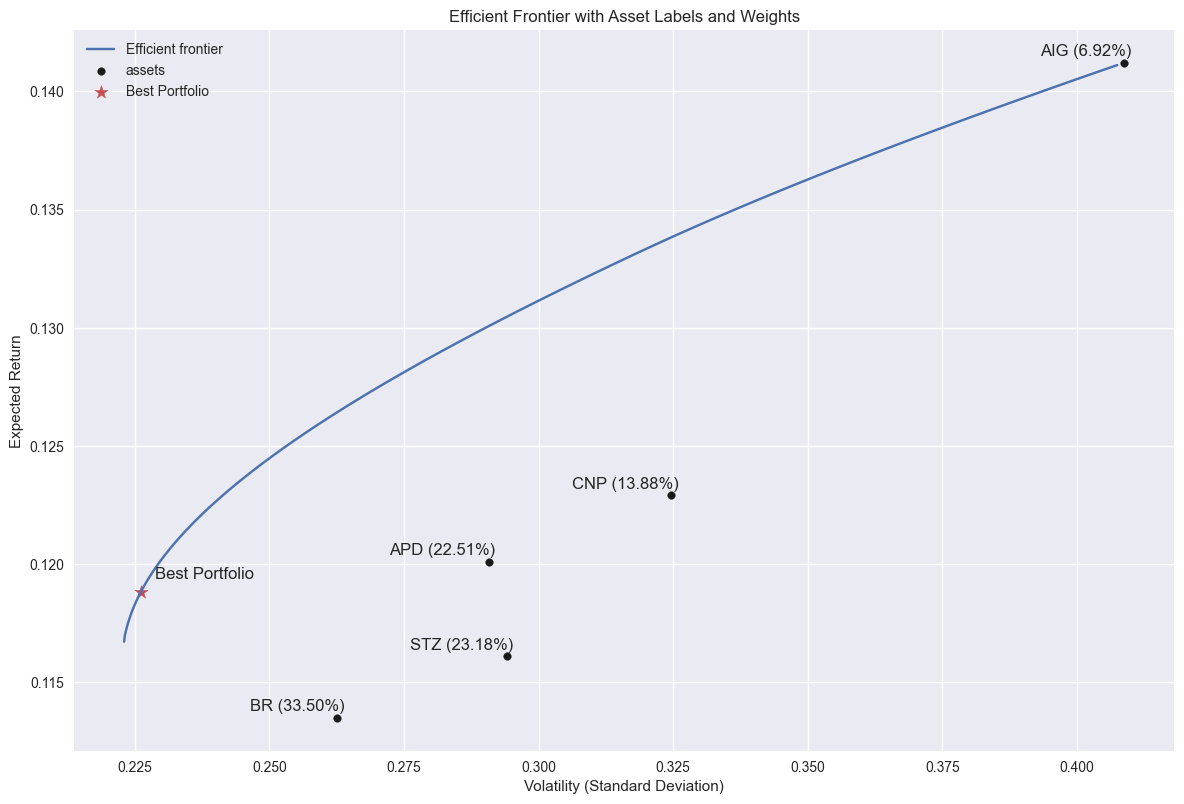

In [64]:
from pypfopt import black_litterman

# Filter clean_stock_data and df_portfolio to include only relevant stocks
portfolio_stocks = df_portfolio['Symbol'].unique()
filtered_data = clean_stock_data[portfolio_stocks]

# Calculate the prior returns and the covariance matrix for filtered stocks
mu = expected_returns.mean_historical_return(filtered_data, frequency=252)
S = risk_models.sample_cov(filtered_data)

# Market-implied risk aversion and equilibrium returns
# Risk free rate is set to the yield from 1-month Treasury bills
delta = black_litterman.market_implied_risk_aversion(mu, risk_free_rate=0.0538)
market_prior = black_litterman.market_implied_prior_returns(mu, delta, S)

# Define simple views and confidences - Adding 10.5% to expected view based on the outperformance of the EF model versus the S&P 500 over the set time frame.
viewdict = {ticker: market_prior[ticker] + 0.105 for ticker in portfolio_stocks}

# We assign a uniform confidence of 0.6 to each view for simplicity. These values can be adjusted based on more detailed analysis or insights.
confidences = {ticker: 0.6 for ticker in portfolio_stocks}

# Setup Black-Litterman model with the views
bl = black_litterman.BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=list(confidences.values()))

# Get the posterior expected returns and covariances
rets_bl = bl.bl_returns()
S_bl = bl.bl_cov()

# Optimize the portfolio using the Black-Litterman adjusted returns
ef_bl = EfficientFrontier(rets_bl, S_bl)
weights_bl = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print("Optimized Portfolio Weights:", cleaned_weights_bl)
perf_bl = ef_bl.portfolio_performance(verbose=True)

# Print expected returns for each stock in the portfolio
print("Expected Returns for Each Stock:")
for ticker in rets_bl.index:
    print(f"{ticker}: {rets_bl[ticker]:.2%}")

# Overlay asset tickers as labels with weights
# Ensure labels are visible and well-placed

# Create a new instance specifically for plotting after the optimization has been performed
plotting_ef = EfficientFrontier(rets_bl, S_bl)

# Create a new figure with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Efficient Frontier
plotting.plot_efficient_frontier(plotting_ef, ax=ax, show_assets=True)

# Initialize a list to collect all text objects for adjustText
texts = []

# Overlay asset tickers as labels with weights
for ticker in cleaned_weights_bl:
    expected_ret = rets_bl[ticker]
    volatility = S_bl.loc[ticker, ticker]**0.5
    weight = cleaned_weights_bl[ticker]

    # Include all stocks, modifying the display of zero-weight stocks if needed
    text = ax.annotate(f"{ticker} ({weight:.2%})", (volatility, expected_ret),
                       xytext=(5, 5), textcoords='offset points', ha='right')
    texts.append(text)

# Add a star marker for the optimal portfolio
ax.scatter(perf_bl[1], perf_bl[0], marker="*", s=100, color='r', label='Best Portfolio')
ax.annotate('Best Portfolio', (perf_bl[1], perf_bl[0]), xytext=(10, 10), textcoords='offset points')

plt.title('Efficient Frontier with Asset Labels and Weights')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

Despite the Black-Litterman being theoretically better than Efficient Frontier, in our test here it has a lower annual return and lower Sharpe Ratio, although the expected volatility is lower, which might be attractive for some investors. Modifying the expected future return would also improve the performance, however we are already using what I believe is a fairly aggressive view based on the S&P 500 return and the results from the Efficient Frontier without Black-Litterman.

### 3d. Hierarchical Risk Parity

<a id='hierarchical_risk_parity'></a>

In [60]:
# Print column names to see if 'Date' exists or if it's already set as the index
print(clean_stock_data.columns)

# If 'Date' is not a column and assuming the index is the date, convert the index to datetime if it's not already
if 'Date' not in clean_stock_data.columns:
    if type(clean_stock_data.index) != pd.DatetimeIndex:
        clean_stock_data.index = pd.to_datetime(clean_stock_data.index)

# Confirm the index is set correctly
print(clean_stock_data.index)

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=499)
DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)


Portfolio stocks: ['CNP' 'APD' 'AIG' 'BR' 'STZ']


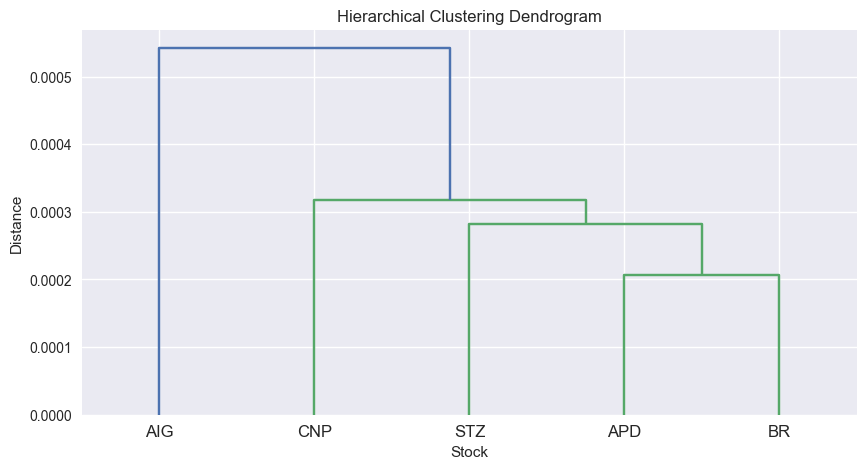

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Display the stocks in the portfolio
print("Portfolio stocks:", portfolio_stocks)

# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Calculate the covariance matrix
cov_matrix = returns.cov()

# Perform hierarchical clustering
Z = linkage(cov_matrix, 'ward')

# Plot the dendrogram
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=portfolio_stocks)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.show()

In [65]:
# Sort Assets Based on Hierarchical Clustering
from scipy.cluster.hierarchy import leaves_list

# Get the order of assets based on the hierarchical tree
sorted_indices = leaves_list(Z)
sorted_assets = portfolio_stocks[sorted_indices]

In [67]:
# Recursive Bisection for Weight Allocation (Maximizing Sharpe Ratio)
# The recursive bisection process involves dividing the portfolio into two halves at each step, optimizing the split point to maximize the Sharpe ratio
# (return per unit of risk) by calculating the Sharpe ratio for different possible splits, and choosing the split that maximizes this ratio and
# finally adjusting the weights based on the volatility and return of each sub-cluster.

from scipy.optimize import minimize_scalar

def sharpe_ratio(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_vol
    return -sharpe_ratio  # Minimize the negative Sharpe ratio for maximization

def find_optimal_split(cov_matrix, returns, assets_order):
    n = len(assets_order)
    if n <= 1:
        return 0, 1  # Base case: no split possible

    def objective(split_point):
        split_point = int(split_point)
        weights_left = np.repeat(1 / split_point, split_point)
        weights_right = np.repeat(1 / (n - split_point), n - split_point)
        weights = np.concatenate([weights_left, weights_right])
        return sharpe_ratio(weights, returns[assets_order], cov_matrix.loc[assets_order, assets_order])

    result = minimize_scalar(objective, bounds=(1, n-1), method='bounded')
    optimal_split_point = int(result.x)
    return optimal_split_point, -result.fun  # Return max Sharpe ratio

def recursive_bisection(cov_matrix, returns, assets_order):
    optimal_split_point, max_sharpe = find_optimal_split(cov_matrix, returns, assets_order)
    if optimal_split_point == 0:
        return {assets_order[0]: 1.0}

    # Recursive calls for each optimal half
    left_assets = assets_order[:optimal_split_point]
    right_assets = assets_order[optimal_split_point:]

    left_weights = recursive_bisection(cov_matrix, returns, left_assets)
    right_weights = recursive_bisection(cov_matrix, returns, right_assets)

    # Combine and normalize weights
    total_weights = {}
    total_weights.update(left_weights)
    total_weights.update(right_weights)
    total_weight = sum(total_weights.values())
    normalized_weights = {k: v / total_weight for k, v in total_weights.items()}
    return normalized_weights

# Calculate expected annual returns for stocks
expected_returns = returns.mean() * 252

# Calculate weights using refined HRP
weights = recursive_bisection(cov_matrix, expected_returns, sorted_assets)

### Calculate portfolio metrics

In [68]:
def calculate_portfolio_metrics(weights, returns, cov_matrix, risk_free_rate=0):
    # Extract the weights and corresponding returns and covariance matrix
    portfolio_weights = np.array([weights.get(ticker, 0) for ticker in returns.index])
    portfolio_returns = returns.values
    portfolio_cov_matrix = cov_matrix.loc[returns.index, returns.index].values

    # Calculate expected annual return
    expected_annual_return = np.sum(portfolio_weights * portfolio_returns)

    # Calculate annual volatility
    annual_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(portfolio_cov_matrix, portfolio_weights)))

    # Calculate Sharpe Ratio
    sharpe_ratio = (expected_annual_return - risk_free_rate) / annual_volatility

    return expected_annual_return, annual_volatility, sharpe_ratio

# Assuming 'expected_returns' and 'cov_matrix' are already defined and contain the correct data
expected_return, volatility, sharpe = calculate_portfolio_metrics(weights, expected_returns, cov_matrix)

print("Optimized Portfolio Weights and Expected Returns for Each Stock:")
for stock in weights:
    print(f"{stock}: Weight = {weights[stock]:.4f}, Expected Annual Return = {expected_returns[stock]:.2%}")

print(f"\nPortfolio Expected Annual Return: {expected_return:.2%}")
print(f"Portfolio Annual Volatility: {volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {sharpe:.4f}")

Optimized Portfolio Weights and Expected Returns for Each Stock:
AIG: Weight = 0.2500, Expected Annual Return = 21.85%
CNP: Weight = 0.1250, Expected Annual Return = 8.68%
STZ: Weight = 0.1250, Expected Annual Return = 13.52%
APD: Weight = 0.2500, Expected Annual Return = 17.30%
BR: Weight = 0.2500, Expected Annual Return = 20.61%

Portfolio Expected Annual Return: 17.72%
Portfolio Annual Volatility: 1.54%
Portfolio Sharpe Ratio: 11.5338


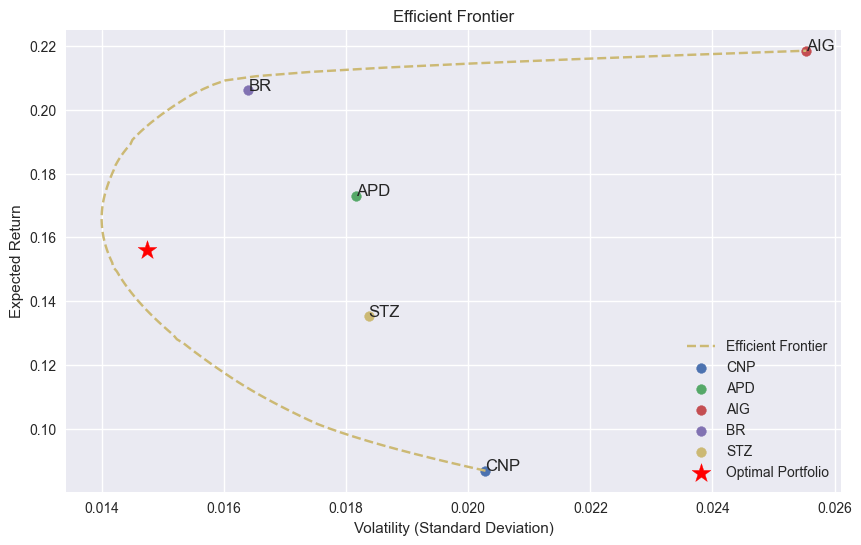

In [75]:
from scipy.optimize import minimize

# Function to calculate portfolio metrics and plot Efficient Frontier
def calculate_portfolio_metrics(weights, returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(returns, weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

def minimize_volatility(weights, returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def plot_efficient_frontier(weights, returns, cov_matrix):
    num_assets = len(weights)
    target_returns = np.linspace(returns.min(), returns.max(), 100)
    frontier_volatility = []

    for ret in target_returns:
        cons = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x, returns, cov_matrix)[0] - ret},
                {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        bounds = tuple((0, 1) for asset in range(num_assets))
        result = minimize(minimize_volatility, num_assets * [1. / num_assets,], args=(returns, cov_matrix),
                          method='SLSQP', bounds=bounds, constraints=cons)
        frontier_volatility.append(portfolio_stats(result.x, returns, cov_matrix)[1])

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(frontier_volatility, target_returns, 'y--', label='Efficient Frontier')
    for symbol in returns.index:
        ax.scatter(np.sqrt(cov_matrix.loc[symbol, symbol]), returns[symbol], label=symbol)
        ax.annotate(symbol, (np.sqrt(cov_matrix.loc[symbol, symbol]), returns[symbol]))

    # Ensure weights are a numpy array for calculations
    weights_array = np.array(list(weights.values()))
    optimal_return, optimal_volatility, _ = calculate_portfolio_metrics(weights_array, returns, cov_matrix)
    ax.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label='Optimal Portfolio')
    ax.set_title("Efficient Frontier")
    ax.set_xlabel("Volatility (Standard Deviation)")
    ax.set_ylabel("Expected Return")
    ax.legend()
    plt.show()

# Call the function
plot_efficient_frontier(weights, expected_returns, cov_matrix)

## Preprocessing and Modeling

<a id='preprocessing'></a>
